# Lab Five for UW AMATH 563
## Assignment: Dogs and Cats Classification with AlexNet
## By Rebecca Lopez

For this lab assignment we implement AlexNet in PyTorch and achieve greater than 85% accuracy within 10 epochs on the Dogs and Cats classification task. 

In [5]:
#Import Necessary Packages & Libraries
import torch
import torchvision
import os
import zipfile
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
import random
from tabulate import tabulate
import torchvision.transforms as T
from torch.autograd import Variable
from torchvision import transforms, datasets
from PIL import Image
import json
import torch
import torchvision
from matplotlib import pyplot as plt
from torch import nn
from torchvision import transforms


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
#Comment out lines below if not using google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
drive  sample_data


NotADirectoryError: ignored

In [9]:
#Define train batch size
train_batch_size = 100 
#Define test batch size (can be larger than train batch size)
test_batch_size  = 100 

# Use the following code to load and normalize the dataset
train_set = torchvision.datasets.ImageFolder('drive/MyDrive/Colab Notebooks/train',
                             transforms.Compose([
                                 transforms.CenterCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
                             ]))
train_set, val_set = torch.utils.data.random_split(train_set, [int(len(train_set)*0.95), int(len(train_set)*0.05)])

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder('drive/MyDrive/Colab Notebooks/test',
                    transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
                    ])),
    batch_size=test_batch_size, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=test_batch_size, shuffle=True)

In [10]:
#Define architecture of network
class AlexNet(nn.Module):
    """
    Neural network model consisting of layers propsed by AlexNet paper.
    """
    def __init__(self, num_classes=1000):
        """
        Define and allocate layers for this neural net.
        Args:
            num_classes (int): number of classes to predict with this model
        """
        super().__init__()
        
#         Define the layers
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, 
                              kernel_size=(11,11), stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride = 2),
            
            nn.Conv2d(in_channels=96, out_channels=256, 
                              kernel_size=(5,5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride = 2),
            
            nn.Conv2d(in_channels=256, out_channels=384, 
                            kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=384, 
                            kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=256, 
                            kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride = 2),
            
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.50),
            nn.Linear(256*6*6, 4096) ,
            nn.ReLU(),
            
            nn.Dropout(0.50),
            nn.Linear(4096, 4096) ,
            nn.ReLU(),
            
            nn.Linear(4096,num_classes)
        )
       
        # initialize bias
        
        #self.init_bias()
        
       
        
    def init_bias(self):
        # Initialize weights according to original paper
        for layer in self.net:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        nn.init.constant_(self.net[3].bias, 1)
        nn.init.constant_(self.net[8].bias, 1)
        nn.init.constant_(self.net[10].bias, 1)

    def forward(self, x):
        x = self.net(x)        
        #Flatten
        x = x.view(x.size(0), -1) 
        out = self.classifier(x)
        return out

In [ ]:
# CNN model training
loss_list = []
iteration_list = []
accuracy_list = []
num_epochs = 10

model = AlexNet(2).to(device)
# model = torch.nn.parallel.DataParallel(model)

#Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
#Define Loss function
error   = nn.CrossEntropyLoss()

prob_list=np.zeros(len(train_loader),)

#Train Network
for epoch in range(num_epochs):
    count = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(images)
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()

        count += 1
        
    # Calculate Accuracy         
    correct = 0
    total = 0
    # Iterate through test dataset
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward propagation
            outputs = model(images)
            # Get predictions from the maximum value
            predicted = torch.argmax(outputs, 1)

            # Total number of labels
            total += len(labels)
            correct += (predicted == labels).sum()

    accuracy = 100 * correct / float(total)

    # store loss and iteration
    loss_list.append(loss.data)
    iteration_list.append(count)
    accuracy_list.append(accuracy)

    # Print Loss
    print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))
    
torch.save(model, 'model.pt')


cuda


100% |########################################################################|


Iteration: 238  Loss: 0.49785441160202026  Accuracy: 70.47999572753906 %


100% |########################################################################|


Iteration: 238  Loss: 0.47994232177734375  Accuracy: 74.47999572753906 %


100% |########################################################################|


Iteration: 238  Loss: 0.30672359466552734  Accuracy: 81.91999816894531 %


100% |########################################################################|


Iteration: 238  Loss: 0.34429478645324707  Accuracy: 83.5999984741211 %


100% |########################################################################|


Iteration: 238  Loss: 0.2924111485481262  Accuracy: 84.72000122070312 %


100% |########################################################################|


Iteration: 238  Loss: 0.49541306495666504  Accuracy: 87.43999481201172 %


100% |########################################################################|


Iteration: 238  Loss: 0.3336365818977356  Accuracy: 87.5199966430664 %


100% |########################################################################|


Iteration: 238  Loss: 0.18589797616004944  Accuracy: 88.63999938964844 %


100% |########################################################################|


Iteration: 238  Loss: 0.2082064300775528  Accuracy: 88.79999542236328 %


100% |########################################################################|


Iteration: 238  Loss: 0.1590326726436615  Accuracy: 88.15999603271484 %


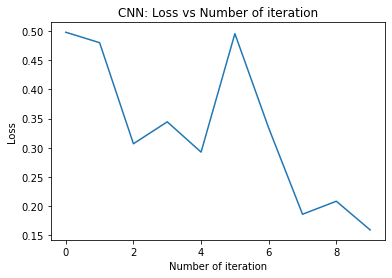

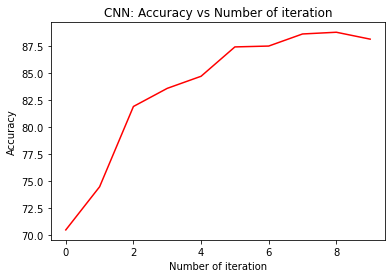

In [ ]:
#Plot for Training loss as a function of Epoch count
with open("loss_list.txt", "w") as fl:
    print(loss_list, file=fl)
plt.plot(loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

#Plot for Validation Accuracy as a function of Epoch count
with open("accuracy_list.txt", "w") as fl:
    print(accuracy_list, file=fl)
plt.plot(accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [12]:
##Uncomment in order to load saved model weights
# import torch
# model = torch.load('/content/drive/MyDrive/Colab Notebooks/model.pt')
# model.eval()

AlexNet(
  (net): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=4096, bias=True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


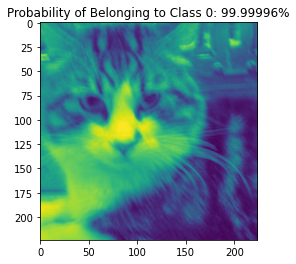

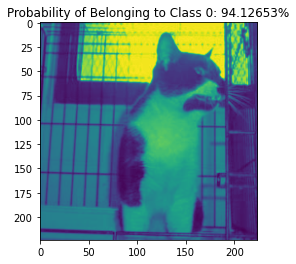

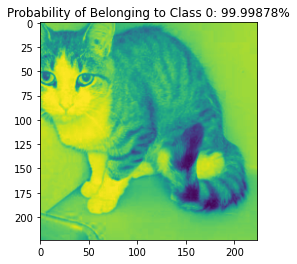

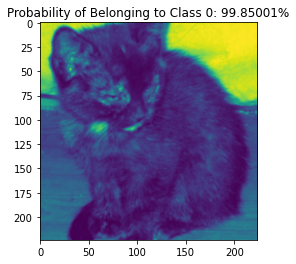

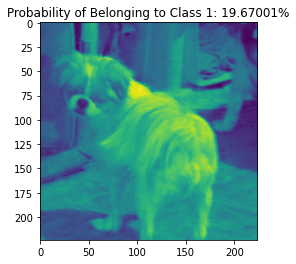

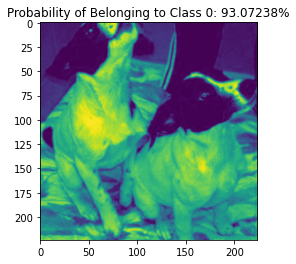

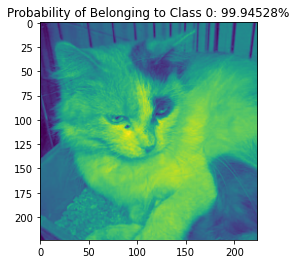

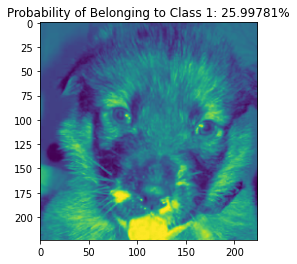

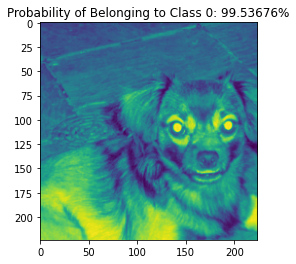

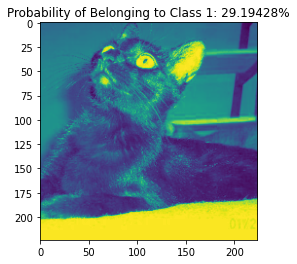

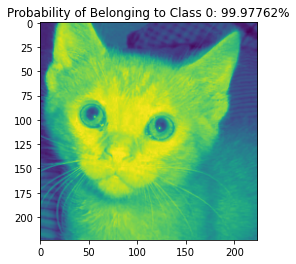

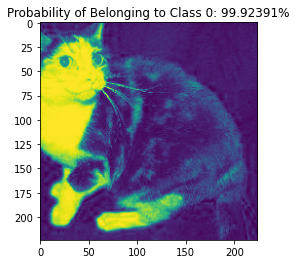

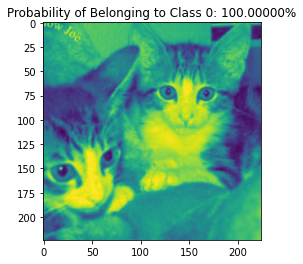

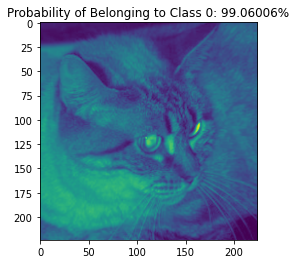

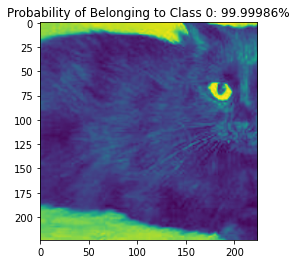

In [34]:
#Plot the first 10 test images with a title that shows the probability of the predicted class
with torch.no_grad():
    for image,label in test_loader:
        image, label = image.to(device), label.to(device)
        out=model(image)
        out=F.softmax(out)
        prediction=torch.argmax(out,dim=1)
        break
           
    for i in range(15):
        plt.imshow(image.detach().cpu().numpy()[i,0,:,:])
        plt.title("Probability of Belonging to Class {}: {:.5%}".format(int(prediction[i]), float(out[i, label[i]])))
        plt.show()

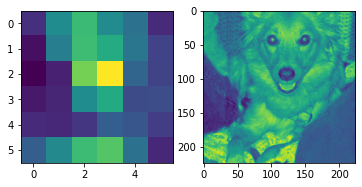

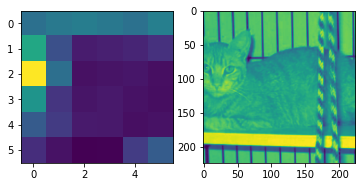

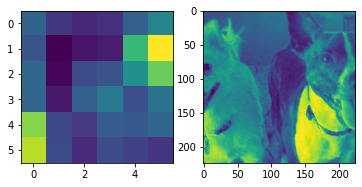

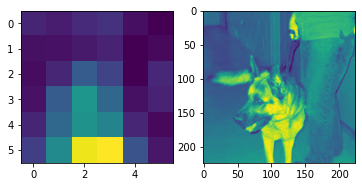

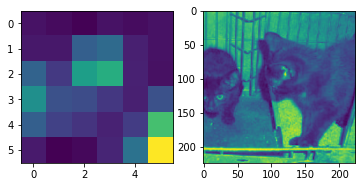

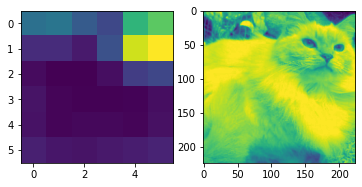

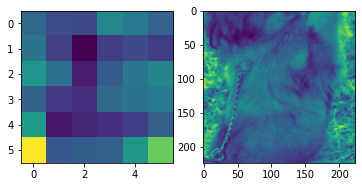

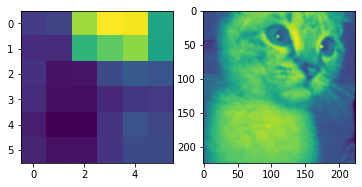

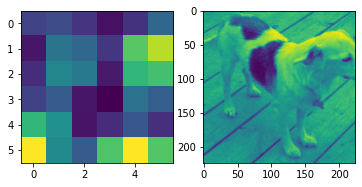

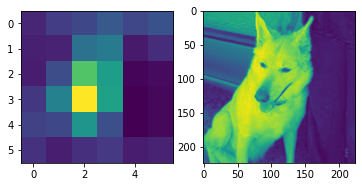

In [33]:
#Visualize the feature maps of some images from the Dogs and Cats classification dataset
with torch.no_grad():
    for image,label in test_loader:
        image, label = image.to(device), label.to(device)
        out=model.net(image)
        feature=torch.sum(out,1)
        break
           
    for i in range(10):
        plt.subplot(1,2,1)
        plt.imshow(feature.detach().cpu().numpy()[i,:,:])
        plt.subplot(1,2,2)
        plt.imshow(image.detach().cpu().numpy()[i,0,:,:])
        plt.show()